In [4]:
from pathlib import Path

DATA_PATH = Path('data')
PATH = DATA_PATH/'cifar10'
TRAIN_PATH = PATH/'train'

In [37]:
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

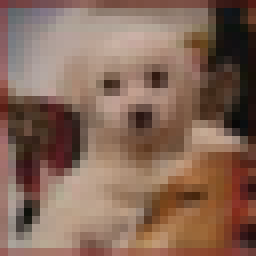

In [8]:
dog_fn = list((TRAIN_PATH/'dog').iterdir())[0]
dog_image = Image.open(dog_fn)
dog_image.resize((256,256))

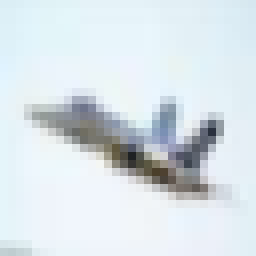

In [9]:
air_fn = list((TRAIN_PATH/'airplane').iterdir())[0]
air_image = Image.open(air_fn)
air_image.resize((256,256))

In [64]:
np.array(air_image)

array([[[219, 238, 245],
        [219, 238, 245],
        [220, 239, 246],
        ...,
        [217, 234, 242],
        [216, 233, 240],
        [214, 231, 240]],

       [[221, 240, 247],
        [221, 240, 247],
        [223, 242, 249],
        ...,
        [219, 237, 245],
        [218, 235, 243],
        [216, 233, 242]],

       [[221, 240, 247],
        [221, 240, 247],
        [223, 242, 249],
        ...,
        [219, 236, 244],
        [218, 235, 243],
        [216, 233, 242]],

       ...,

       [[229, 245, 250],
        [230, 244, 249],
        [232, 244, 250],
        ...,
        [229, 240, 246],
        [227, 240, 246],
        [226, 240, 245]],

       [[216, 230, 234],
        [218, 232, 236],
        [222, 236, 239],
        ...,
        [229, 240, 247],
        [227, 240, 246],
        [225, 239, 245]],

       [[194, 208, 211],
        [191, 205, 208],
        [197, 211, 214],
        ...,
        [229, 240, 247],
        [227, 240, 246],
        [225, 239, 245]]

# Simple Dataset/Dataloader

In [185]:
import torch
default_device = torch.device('cuda', 0)

In [81]:
from torch.utils.data import Dataset, DataLoader

class FilesDataset(Dataset):
    def __init__(self, Path):
        self.classes, self.fns, self.y = [], [], []
        for i, cls_dir in enumerate(Path.iterdir()):
            self.classes.append(cls_dir.name)
            fnames = list(cls_dir.glob('*'))
            self.fns += fnames
            self.y += [i] * len(fnames)
        
    def __len__(self): return len(self.fns)

    def __getitem__(self,i):
        x = Image.open(self.fns[i])
        return torch.Tensor(np.array(x)),self.y[i]

In [82]:
trn_ds = FilesDataset(PATH/'train')
val_ds = FilesDataset(PATH/'test')

In [83]:
len(trn_ds), len(val_ds)

(50000, 10000)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


dog


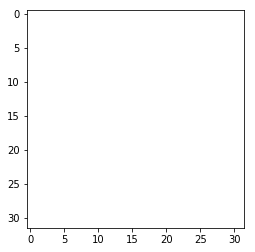

In [84]:
i = np.random.randint(len(trn_ds))
x,y = trn_ds[i]
plt.imshow(x)
print(trn_ds.classes[y])

In [104]:
class DeviceDataLoader():
    def __init__(self, dl, device):
        self.dl,self.device = dl,device
        
    def __iter__(self):
        for b in self.dl: yield [o.to(self.device) for o in b]
    
    def __len__(self): return (len(self.dl))

In [86]:
def get_dataloader(ds, bs, shuffle, device):
    return DeviceDataLoader(DataLoader(ds, batch_size=bs, shuffle=shuffle), device)

In [99]:
class DataBunch():
    def __init__(self, trn_ds, val_ds, bs=64, device=None):
        self.device = default_device if device is None else device
        if hasattr(trn_ds, 'classes'): self.classes = trn_ds.classes
        self.train_dl = get_dataloader(trn_ds, bs,   shuffle=True,  device=self.device)
        self.valid_dl = get_dataloader(val_ds, bs*2, shuffle=False, device=self.device)

    @classmethod #Insure compatibility with previous notebook
    def from_arrays(cls, x_train, y_train, x_valid, y_valid, bs=64, device=None):
        x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
        trn_ds, val_ds = TensorDataset(x_train, y_train), TensorDataset(x_valid, y_valid)
        return cls(trn_ds, val_ds, bs, device)

    @classmethod
    def from_files(cls, Path, val_name='valid', bs=64, device=None):
        trn_ds, val_ds = FilesDataset(Path/'train'), FilesDataset(Path/val_name)
        return cls(trn_ds, val_ds, bs, device)

In [100]:
data = DataBunch.from_files(PATH, val_name='test')

In [101]:
len(data.train_dl), len(data.valid_dl)

(782, 79)

In [90]:
x,y = next(iter(data.train_dl))

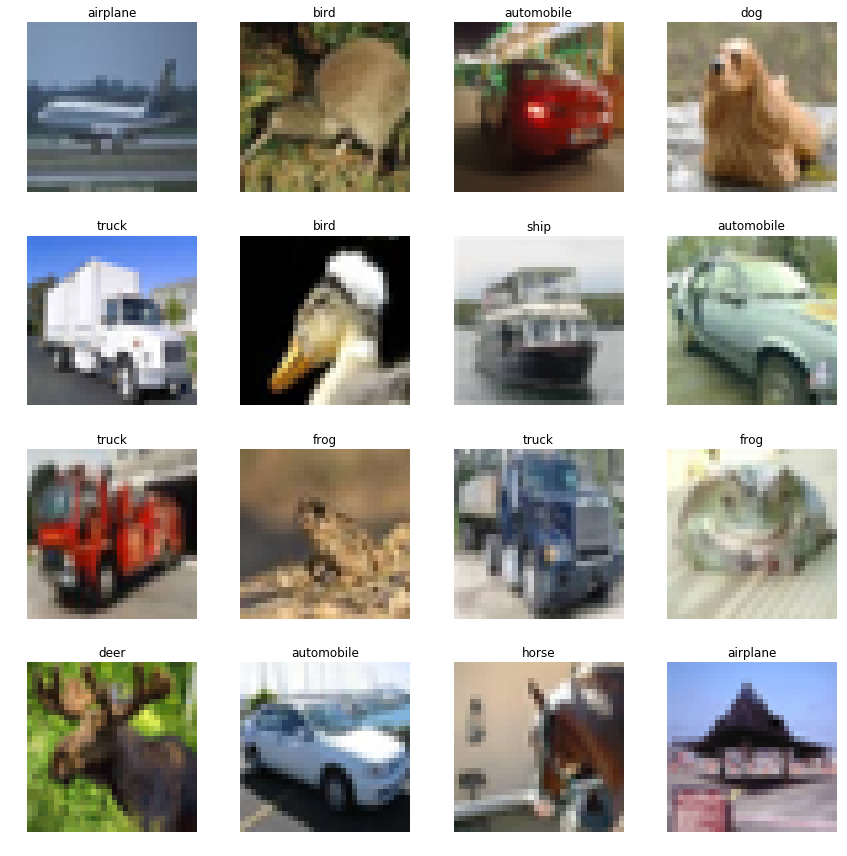

In [103]:
fig, axs = plt.subplots(4,4,figsize=(12,12))
for i, ax in enumerate(axs.flatten()):
    ax.imshow(x[i].cpu().numpy().astype(np.int16))
    ax.axis('off')
    ax.set_title(data.classes[y[i]])
plt.tight_layout()

## Add transforms

A basic generic transform should have:
- a function that describes the transformation for x and eventually y
- a tfm_type for y so we know what to do with it
- a level to apply it: image transform or batch transform, and if it's applied at a batch level, a set_device method
- a probability of happening (if 1, happens all the time)

In [105]:
from enum import IntEnum

class TfmType(IntEnum):
    NO = 1
    PIXEL = 2
    COORD = 3
    CLASS = 4

In [107]:
from abc import abstractmethod

In [112]:
class Transform():
    
    def __init__(self, tfm_y=TfmType.NO, p=1, batch_lvl = False):
        self.tfm_y,self.p,self.batch_lvl = tfm_y,p,batch_lvl
    
    def __call__(self, x, y):
        x,y = ((self.transform(x),y) if self.tfm_y==TfmType.NO
                else self.transform(x,y) if self.tfm_y in (TfmType.PIXEL, TfmType.CLASS)
                else self.transform_coord(x,y))
        return x, y
    
    def set_device(self, device):
        if not self.batch_lvl: self.device = device
    
    def transform_coord(self, x, y):
        if self.p == 1 or np.random.rand < self.p:
            return self.transform(x),y

    def transform(self, x, y=None):
        if self.p == 1 or np.random.rand < self.p:
            x = self.do_transform(x,False)
            return (x, self.do_transform(y,True)) if y is not None else x
        else: return x,y
    
    @abstractmethod
    def do_transform(self, x, is_y): raise NotImplementedError
    #In do_transform we can save a value (angle of a random rotation for instance) in self.save_for_y that will be used
    #if is_y is True.

In [113]:
class ChannelOrder(Transform):
    #If we use PIL for data augmentation, maybe the conversion to a numpy array should be handled here?
    def __init__(self, tfm_y=TfmType.NO):
        super().__init__(tfm_y=tfm_y)
    
    def do_transform(self, x, is_y):
        if not is_y or self.tfm_y == TfmType.PIXEL: x = np.rollaxis(x, 2)
        return x

In [217]:
class Normalize(Transform):
    
    def __init__(self, means, stds, tfm_y=TfmType.NO):
        self.means,self.stds = means,stds
        super().__init__(tfm_y=tfm_y, batch_lvl=True)
    
    def set_device(self, device):
        super().set_device(device)
        if type(self.means) != torch.Tensor or not self.means.device == device:
            self.means,self.stds = map(lambda x:torch.Tensor(x).to(device), (self.means, self.stds))
    
    def do_transform(self, x, is_y):
        if not is_y or self.tfm_y == TfmType.PIXEL:
            m, s = self.means[None,:,None,None].type_as(x), self.stds[None,:,None,None].type_as(x)
            x = (x - m) / s
        return x

In [187]:
def compose(tfms, x, y):
    for tfm in tfms: x,y = tfm(x,y)
    return x,y

In [188]:
class FilesDataset(Dataset):
    def __init__(self, Path, tfms):
        self.tfms = tfms
        self.classes,self.fns,self.y = [],[],[]
        for i, cls_dir in enumerate(Path.iterdir()):
            self.classes.append(cls_dir.name)
            fnames = list(cls_dir.glob('*'))
            self.fns += fnames
            self.y += [i] * len(fnames)
        
    def __len__(self): return len(self.fns)

    def __getitem__(self,i):
        x = Image.open(self.fns[i])
        return compose(self.tfms, np.array(x)/255,self.y[i])

In [204]:
class DeviceDataLoader():
    def __init__(self, dl, device, tfms):
        self.dl,self.device,self.tfms = dl,device,tfms
        for tfm in tfms: tfm.set_device(device)
        
    def __iter__(self):
        for b in self.dl: yield compose(self.tfms,b[0].to(self.device),b[1].to(self.device))
    
    def __len__(self): return (len(self.dl))

In [190]:
def split_one_tfms(tfms):
    ds_tfms = [tfm for tfm in tfms if not tfm.batch_lvl]
    dl_tfms = [tfm for tfm in tfms if tfm.batch_lvl]
    return ds_tfms,dl_tfms
    
def split_tfms(trn_tfms, val_tfms):
    trn_ds_tfms, trn_dl_tfms = split_one_tfms(trn_tfms)
    val_ds_tfms, val_dl_tfms = split_one_tfms(val_tfms)
    return trn_ds_tfms, val_ds_tfms, trn_dl_tfms, val_dl_tfms

In [191]:
def get_dataloader(ds, bs, shuffle, device, tfms):
    return DeviceDataLoader(DataLoader(ds, batch_size=bs, shuffle=shuffle), device, tfms)

In [192]:
class DataBunch():
    def __init__(self, trn_ds, val_ds, trn_tfms, val_tfms, bs=64, device=None):
        self.device = default_device if device is None else device
        if hasattr(trn_ds, 'classes'): self.classes = trn_ds.classes
        self.train_dl = get_dataloader(trn_ds, bs,   shuffle=True,  device=self.device, tfms=trn_tfms)
        self.valid_dl = get_dataloader(val_ds, bs*2, shuffle=False, device=self.device, tfms=val_tfms)
        
    @classmethod #Insure compatibility with previous notebook
    def from_arrays(cls, x_train, y_train, x_valid, y_valid, trn_tfms, val_tfms, bs=64, device=None):
        x_train,y_train,x_valid,y_valid = map(torch.tensor, (x_train,y_train,x_valid,y_valid))
        trn_ds_tfms, val_ds_tfms, trn_dl_tfms, val_dl_tfms = self.split_tfms(trn_tfms, val_tfms)
        trn_ds = TransformedDataset(x_train, y_train,trn_ds_tfms)
        val_ds = TransformedDataset(x_valid, y_valid,trn_ds_tfms)
        return cls(trn_ds, val_ds, trn_dl_tfms, val_dl_tfms, bs, device)

    @classmethod
    def from_files(cls, Path, trn_tfms, val_tfms, val_name='valid', bs=64, device=None):
        trn_ds_tfms, val_ds_tfms, trn_dl_tfms, val_dl_tfms = split_tfms(trn_tfms, val_tfms)
        trn_ds, val_ds = FilesDataset(Path/'train',trn_ds_tfms), FilesDataset(Path/val_name,val_ds_tfms)
        return cls(trn_ds, val_ds, trn_dl_tfms, val_dl_tfms, bs, device)

In [218]:
stats = (np.array([ 0.4914 ,  0.48216,  0.44653]), np.array([ 0.24703,  0.24349,  0.26159]))
tfms = [ChannelOrder(), Normalize(stats[0], stats[1])]

In [219]:
data = DataBunch.from_files(PATH, tfms, tfms, val_name='test')

In [220]:
len(data.train_dl), len(data.valid_dl)

(782, 79)

In [221]:
x,y = next(iter(data.train_dl))

In [222]:
x[0]

tensor([[[-0.0684,  0.2809,  0.5507,  ..., -1.2114, -1.2749, -1.1161],
         [-0.0684,  0.2015,  0.3602,  ..., -0.9891, -1.0526, -1.1320],
         [-0.2589, -0.2906, -0.0366,  ..., -0.9574, -1.0050, -1.1479],
         ...,
         [ 1.8366,  1.6937,  1.7414,  ...,  1.6779,  1.6779,  1.7096],
         [ 1.8684,  1.7572,  1.8207,  ...,  1.7572,  1.6620,  1.7096],
         [ 2.0589,  1.9795,  1.9954,  ...,  1.8684,  1.8049,  1.8684]],

        [[ 0.0491,  0.3873,  0.6128,  ..., -1.0622, -1.1105, -0.9494],
         [ 0.0169,  0.2907,  0.4518,  ..., -0.7562, -0.8367, -0.9011],
         [-0.1119, -0.1281,  0.1618,  ..., -0.7401, -0.8045, -0.9333],
         ...,
         [ 1.6919,  1.5308,  1.5630,  ...,  1.5791,  1.5791,  1.6114],
         [ 1.7563,  1.6114,  1.6597,  ...,  1.6758,  1.5791,  1.6275],
         [ 1.9979,  1.8690,  1.8690,  ...,  1.7885,  1.7241,  1.7724]],

        [[ 0.1369,  0.3918,  0.6317,  ..., -1.1373, -1.1973, -1.0474],
         [ 0.0320,  0.2869,  0.4368,  ..., -0

In [223]:
y[0]

tensor(7, device='cuda:0')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


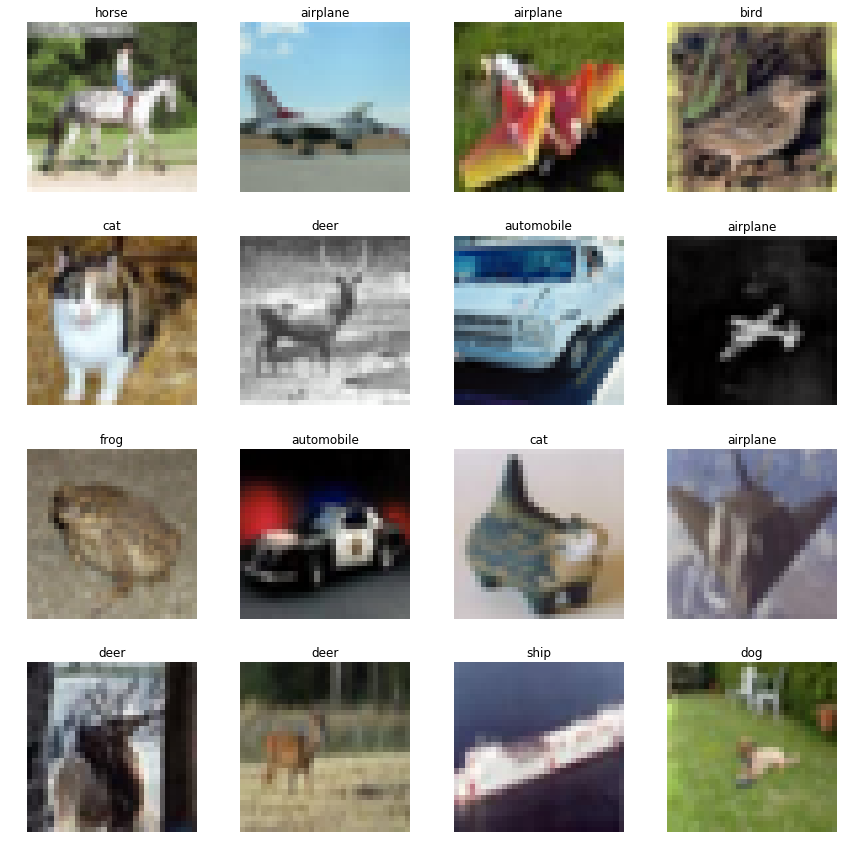

In [224]:
fig, axs = plt.subplots(4,4,figsize=(12,12))
for i, ax in enumerate(axs.flatten()):
    img = x[i].cpu().numpy().transpose(1,2,0)
    img = img * stats[1] + stats[0]
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(data.classes[y[i].item()])
plt.tight_layout()